# Stock data preprocessing

## Imports

In [ ]:
pip install finnhub-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install fredapi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import finnhub
import pandas as pd
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from fredapi import Fred
import json
import requests
from bs4 import BeautifulSoup
from lxml import etree
import tensorflow as tf
from tensorflow.keras import activations
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error,mean_absolute_error
from tables import index

## Init Variable

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
COMPANY_TICKET="HD"

In [ ]:
STOCK_PRICE_API_KEY="cgi68s9r01qnl59fgu50cgi68s9r01qnl59fgu5g"
FRED_ECONOMIC_DATA_API_KEY="b55a691bfde4da73b304315a5195ae35"
ALPHA_VANTAGE_API_KEY="QJQRYGCYXWVZTYG4"

In [ ]:
init_date = "2013-01-01"
quarter_init_date = "2006-01-31"

init_datetime_obj = datetime.strptime(init_date, '%Y-%m-%d')

last_datetime_obj = datetime.now()

start_timestamp = int(time.mktime(init_datetime_obj.timetuple()))

last_timestamp = int(time.mktime(last_datetime_obj.timetuple()))

## Stock Price

In [ ]:
# Setup client
finnhub_client = finnhub.Client(api_key=STOCK_PRICE_API_KEY)

In [ ]:
res = finnhub_client.stock_candles(COMPANY_TICKET, 'D', start_timestamp, last_timestamp)

In [ ]:
STOCK_PRICE_Data= pd.DataFrame(res)

In [ ]:
STOCK_PRICE_Data["date"]=pd.to_datetime(STOCK_PRICE_Data['t'], unit="s")

In [ ]:
STOCK_PRICE_Data['date'] = STOCK_PRICE_Data['date']

In [ ]:
STOCK_PRICE_Data = STOCK_PRICE_Data.rename(columns={'c': 'closePrice', 'h': 'highestPrice',"l":"lowestPrice","o":"openPrice","v":"volumen",'date':"StockPriceDate"})

In [ ]:
STOCK_PRICE_Data=STOCK_PRICE_Data[["StockPriceDate","closePrice","highestPrice","lowestPrice","openPrice","volumen"]]

In [ ]:
STOCK_PRICE_Data.head(5)

,StockPriceDate,closePrice,highestPrice,lowestPrice,openPrice,volumen
0,2013-01-02,63.4800,63.71,62.61,63.57,9072207
1,2013-01-03,63.3000,63.93,63.08,63.78,6057180
2,2013-01-04,63.1800,63.37,63.00,63.21,4780124
3,2013-01-07,62.8412,63.00,62.38,62.60,5467113
4,2013-01-08,63.2200,63.46,62.73,62.75,5433220


In [ ]:
fig = go.Figure(data=[go.Candlestick(x=STOCK_PRICE_Data["StockPriceDate"],
                open=STOCK_PRICE_Data["openPrice"],
                high=STOCK_PRICE_Data["highestPrice"],
                low=STOCK_PRICE_Data["lowestPrice"],
                close=STOCK_PRICE_Data["closePrice"])])
fig.show()

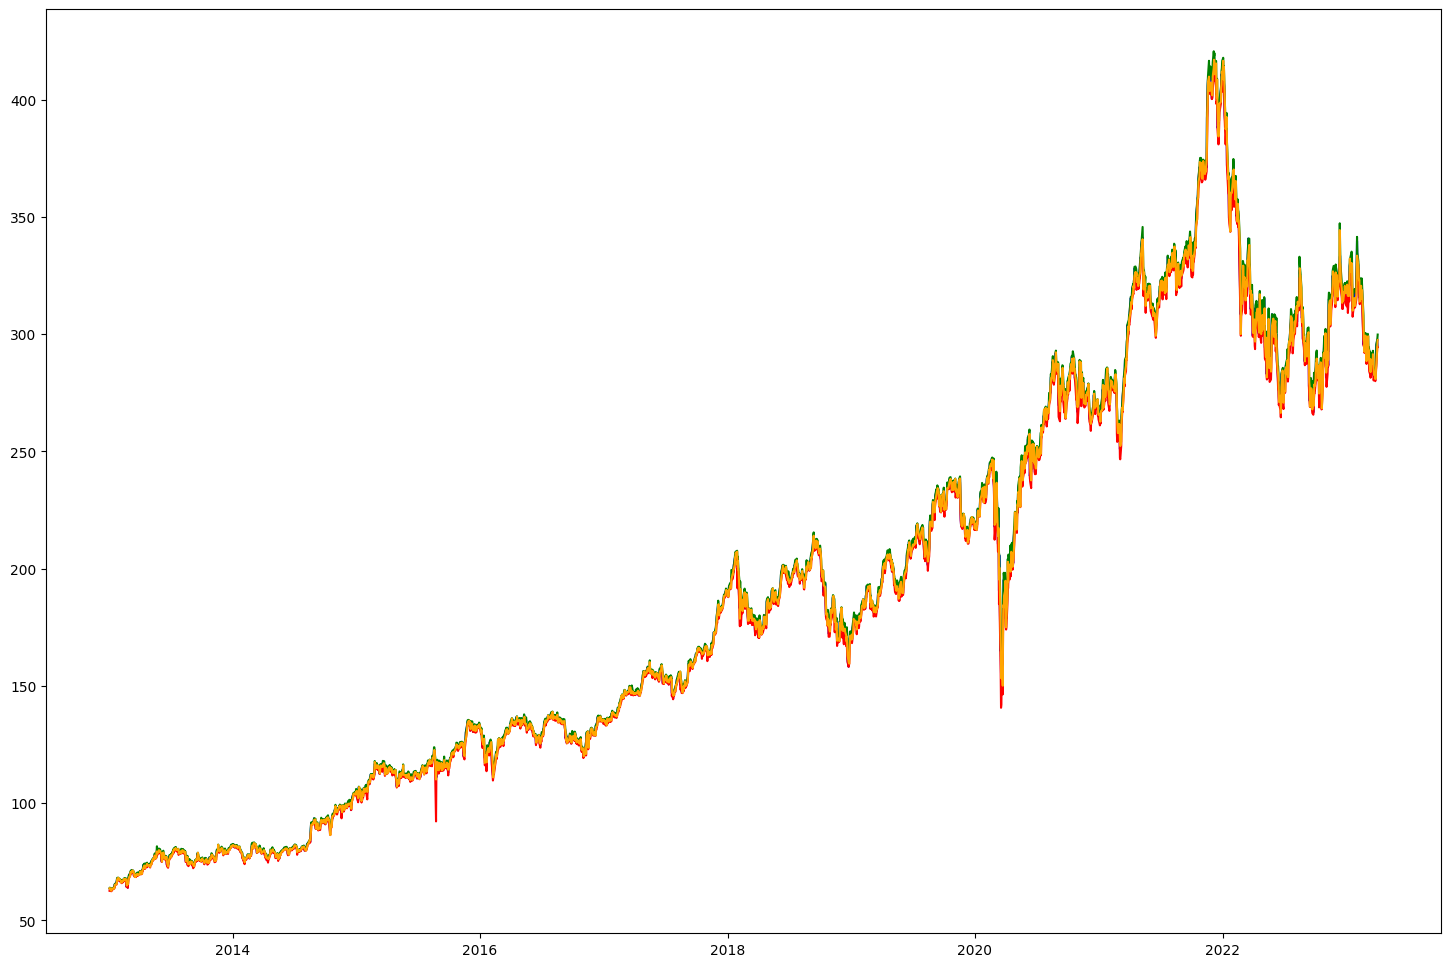

In [ ]:
plt.figure(figsize=(18,12))
plt.plot(STOCK_PRICE_Data["StockPriceDate"],STOCK_PRICE_Data["closePrice"], color="blue")
plt.plot(STOCK_PRICE_Data["StockPriceDate"],STOCK_PRICE_Data["highestPrice"], color="green")
plt.plot(STOCK_PRICE_Data["StockPriceDate"],STOCK_PRICE_Data["lowestPrice"], color="red")
plt.plot(STOCK_PRICE_Data["StockPriceDate"],STOCK_PRICE_Data["openPrice"], color="orange")
plt.show()

## Creating ratios DF

In [ ]:
ratios_annual= pd.DataFrame()
ratios_quarterly= pd.DataFrame()

In [ ]:
url_annual = f'https://stockanalysis.com/stocks/{COMPANY_TICKET.lower()}/financials/ratios/' #annual

page_annual = requests.get(url_annual)
soup_annual = BeautifulSoup(page_annual.content,'html.parser')
dom_annual = etree.HTML(str(soup_annual))

url_quarterly = f'https://stockanalysis.com/stocks/{COMPANY_TICKET.lower()}/financials/ratios/?p=quarterly' #quarterly

page_quarterly = requests.get(url_quarterly)
soup_quarterly = BeautifulSoup(page_quarterly.content,'html.parser')
dom_quarterly= etree.HTML(str(soup_quarterly))


cashflow_url_annual = f'https://stockanalysis.com/stocks/{COMPANY_TICKET.lower()}/financials/cash-flow-statement/' #annual

cash_flow_page_annual = requests.get(cashflow_url_annual)
cash_flow_soup_annual = BeautifulSoup(cash_flow_page_annual.content,'html.parser')
cash_flow_dom_annual = etree.HTML(str(cash_flow_soup_annual))

cashflow_url_quarterly = f'https://stockanalysis.com/stocks/{COMPANY_TICKET.lower()}/financials/cash-flow-statement/?p=quarterly' #quarterly

cash_flow_page_quarterly = requests.get(cashflow_url_quarterly)
cash_flow_soup_quarterly = BeautifulSoup(cash_flow_page_quarterly.content,'html.parser')
cash_flow_dom_quarterly = etree.HTML(str(cash_flow_soup_quarterly))


In [ ]:
def getRatio(ratioName, currentDom):
  return currentDom.xpath(f'(//td/span[text()="{ratioName}"]/parent::td/parent::tr)/td[position() > 1 and position() < last()]/text()')

In [ ]:
def getCashFlowData(dataName, currentDom):
  return currentDom.xpath(f'(//td/span[text()="{dataName}"]/parent::td/parent::tr)/td[position() > 1 and position() < last()]/text()')

In [ ]:
## Pendientes : Price to Book Value, QuickRatio, Cash Ratio
annual_dates=np.array(dom_annual.xpath('(//th[text()="Year"]/parent::tr)/th[position() > 1 and position() < last()]/text()')).astype(str)
quarterly_dates=np.array(dom_quarterly.xpath('(//th[text()="Quarter Ended"]/parent::tr)/th[position() > 1 and position() < last()]/text()')).astype(str)

Current_Ratio_annual=np.array(getRatio("Current Ratio",dom_annual)).astype(float)
Current_Ratio_quarterly=np.array(getRatio("Current Ratio",dom_quarterly)).astype(float)


PE_Ratio_annual=np.array(getRatio("PE Ratio",dom_annual)).astype(float)
PE_Ratio_quarterly=np.array(getRatio("PE Ratio",dom_quarterly)).astype(float)

DE_Ratio_annual=np.array(getRatio("Debt / Equity Ratio",dom_annual)).astype(float)
DE_Ratio_quarterly=np.array([np.nan if x == '-' else float(x) for x in getRatio("Debt / Equity Ratio",dom_quarterly)]).astype(float)

Asset_Turnover_annual = np.array(getRatio("Asset Turnover",dom_annual)).astype(float)

ROE_percent_annual= getRatio("Return on Equity (ROE)",dom_annual)

PE_ratio_annual= np.array(getRatio("PE Ratio",dom_annual)).astype(float)
PE_ratio_quarterly= np.array(getRatio("PE Ratio",dom_quarterly)).astype(float)

PS_ratio_annual=np.array(getRatio("PS Ratio",dom_annual)).astype(float)
PS_ratio_quarterly=np.array(getRatio("PS Ratio",dom_quarterly)).astype(float)

In [ ]:
free_Cash_Flow_Per_Share_annual=np.array(getRatio("Free Cash Flow Per Share",cash_flow_dom_annual))
free_Cash_Flow_Per_Share_quarterly=np.array(getRatio("Free Cash Flow Per Share",cash_flow_dom_quarterly))

In [ ]:
ratios_annual["Annual_RatiosDate"]=annual_dates
ratios_quarterly["Quarterly_RatiosDate"]=quarterly_dates

In [ ]:
ratios_annual["Annual_Current_Ratio"]=Current_Ratio_annual
ratios_quarterly["Quarterly_Current_Ratio"]=Current_Ratio_quarterly

In [ ]:
ratios_annual["Annual_PE_Ratio"]=PE_Ratio_annual
ratios_quarterly["Quarterly_PE_Ratio"]=PE_Ratio_quarterly

In [ ]:
ratios_annual["Annual_Debt_Equity _Ratio"]=DE_Ratio_annual
ratios_quarterly["Quarterly_PE_Debt_EquityRatio"]=DE_Ratio_quarterly

In [ ]:
ratios_annual["Annual_Asset_Turnover_annual"]=Asset_Turnover_annual

In [ ]:
ratios_annual["Annual_ROE%_decimal"]=np.core.defchararray.replace(ROE_percent_annual, '%', '')
ratios_annual["Annual_ROE%_decimal"] = ratios_annual["Annual_ROE%_decimal"].astype(float) / 100

In [ ]:
ratios_annual["Annual_PE_Ratio"]=PE_ratio_annual
ratios_quarterly["Quarterly_PE_Ratio"]=PE_ratio_quarterly

In [ ]:
ratios_annual["Annual_PS_Ratio"]=PS_ratio_annual
ratios_quarterly["Quarterly_PS_Ratio"]=PS_ratio_quarterly

In [ ]:
ratios_annual.dtypes

Annual_RatiosDate                object
Annual_Current_Ratio            float64
Annual_PE_Ratio                 float64
Annual_Debt_Equity _Ratio       float64
Annual_Asset_Turnover_annual    float64
Annual_ROE%_decimal             float64
Annual_PS_Ratio                 float64
dtype: object

In [ ]:
ratios_annual.drop(index=ratios_annual.index[0], axis=0, inplace=True)
ratios_annual["Annual_RatiosDate"]=ratios_annual["Annual_RatiosDate"].astype(int)
ratios_quarterly.drop(index=ratios_quarterly.index[0], axis=0, inplace=True)

ratios_quarterly["Quarterly_RatiosDate"]=pd.to_datetime(ratios_quarterly['Quarterly_RatiosDate'])

ratios_annual = ratios_annual.sort_values(by='Annual_RatiosDate', ascending=True)
ratios_quarterly = ratios_quarterly.sort_values(by='Quarterly_RatiosDate', ascending=True)

In [ ]:
ratios_annual

,Annual_RatiosDate,Annual_Current_Ratio,Annual_PE_Ratio,Annual_Debt_Equity _Ratio,Annual_Asset_Turnover_annual,Annual_ROE%_decimal,Annual_PS_Ratio
10,2013,1.42,20.10,1.18,1.85,0.368,1.37
9,2014,1.36,21.69,1.84,1.99,0.590,1.65
8,2015,1.32,22.75,3.36,2.05,0.882,1.80
7,2016,1.25,21.18,5.45,2.15,1.387,1.78
6,2017,1.17,28.04,18.59,2.24,2.998,2.40
5,2018,1.11,18.73,-15.55,2.38,14.176,1.93
4,2019,1.08,22.13,-12.00,2.13,-5.995,2.26
3,2020,1.23,22.66,13.16,2.04,55.338,2.21
2,2021,1.01,23.29,-27.28,2.10,20.828,2.53
1,2022,1.41,18.87,32.24,2.06,49.294,2.05


In [ ]:
def plotRatios(ratiosDF,ratioPeriodName, stockName, dateColumnName):
  nrows = int((len(ratiosDF.columns)-1) / 2) + (len(ratiosDF.columns)-1) % 2
  ncols = 2
  fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18,10))
  for i, col in enumerate(ratiosDF.columns[1:]):
    row = int(i / ncols)
    col_axis = i % ncols
    axs[row, col_axis].plot(ratiosDF[dateColumnName],ratiosDF[col])
    axs[row, col_axis].set_title(col)

  fig.suptitle(f"{ratioPeriodName} Ratios of Stock: {stockName}")
  plt.show()

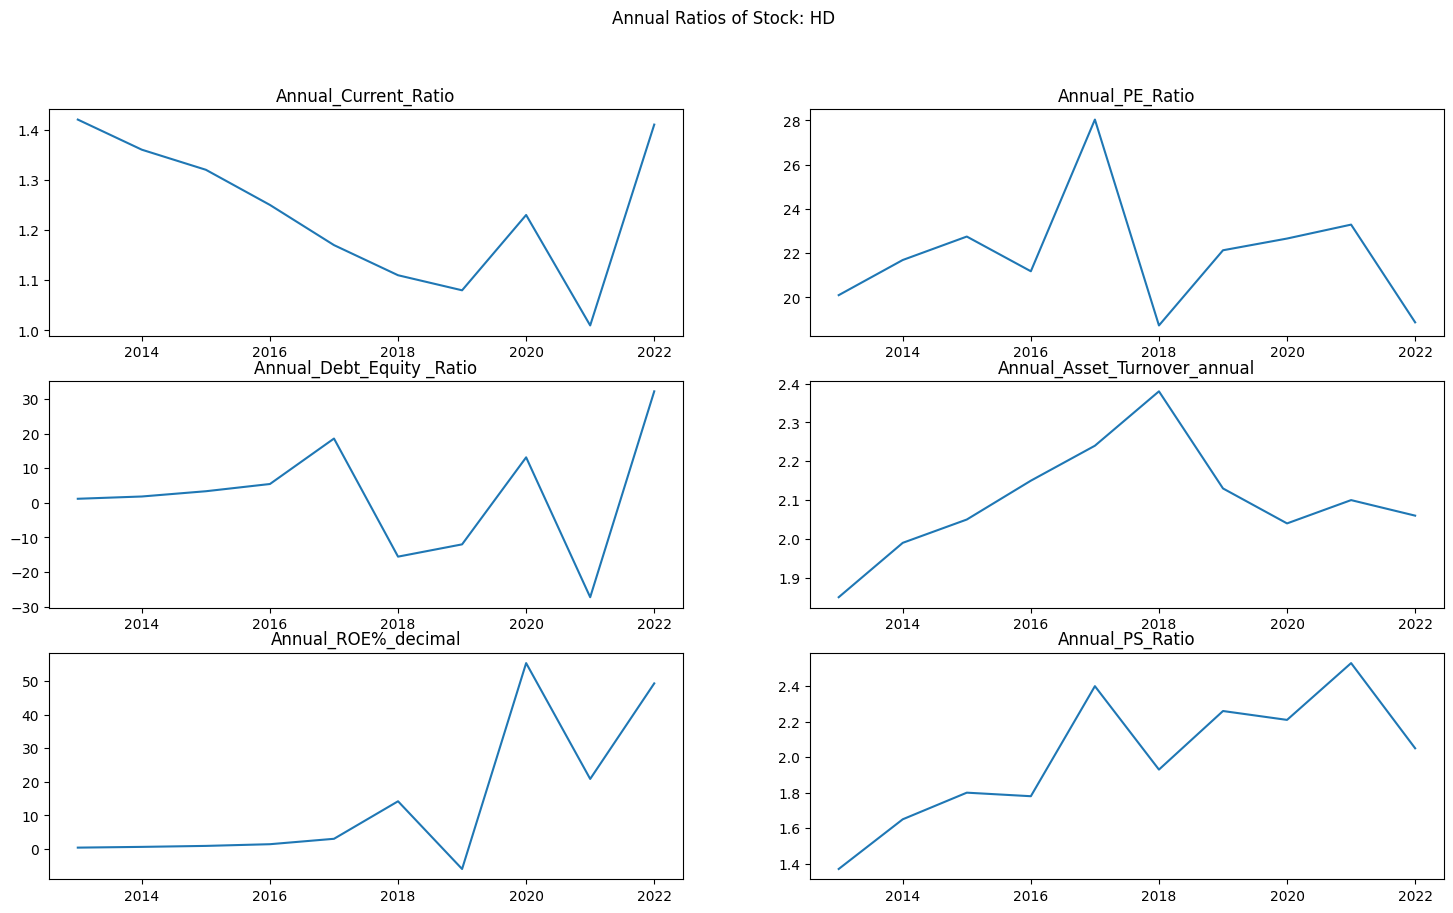

In [ ]:
plotRatios(ratios_annual,"Annual", COMPANY_TICKET,"Annual_RatiosDate")

In [ ]:
ratios_quarterly.head(5)

,Quarterly_RatiosDate,Quarterly_Current_Ratio,Quarterly_PE_Ratio,Quarterly_PE_Debt_EquityRatio,Quarterly_PS_Ratio
40,2013-05-05,1.33,23.25,0.78,1.44
39,2013-08-04,1.30,23.49,0.82,1.50
38,2013-11-03,1.48,20.45,1.13,1.39
37,2014-02-02,1.42,20.10,1.18,1.37
36,2014-05-04,1.32,19.81,1.21,1.38


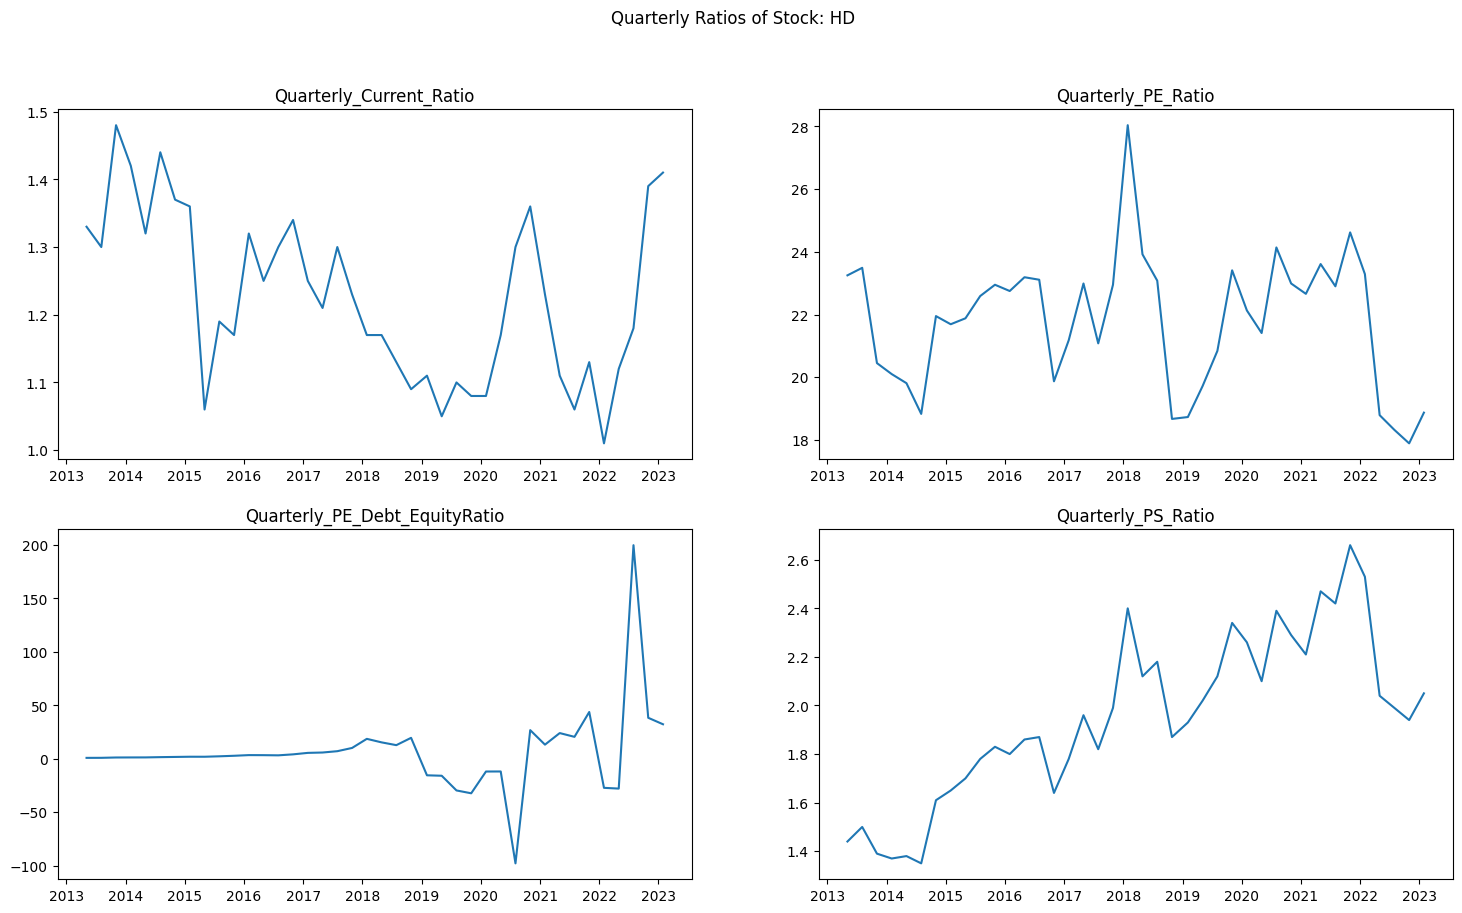

In [ ]:
plotRatios(ratios_quarterly,"Quarterly",COMPANY_TICKET,"Quarterly_RatiosDate")

## Sentiment analysis

In [ ]:
url = 'https://www.alphavantage.co/query'
r = requests.get(url, params={"function":"EARNINGS","symbol":COMPANY_TICKET,"apikey":ALPHA_VANTAGE_API_KEY})
data = r.json()

Surprise_EPS_data_quarterly= json.dumps(data['quarterlyEarnings'])
Surprise_EPS_data_quarterly = pd.read_json(Surprise_EPS_data_quarterly)

#Surprise_EPS_data_quarterly=Surprise_EPS_data_quarterly[["fiscalDateEnding","reportedDate","surprise"]]
Surprise_EPS_data_quarterly=Surprise_EPS_data_quarterly[["fiscalDateEnding","surprise"]]


In [ ]:
Surprise_EPS_data_quarterly

,fiscalDateEnding,surprise
0,2023-01-31,0.02
1,2022-10-31,0.12
2,2022-07-31,0.11
3,2022-04-30,0.41
4,2022-01-31,0.03
...,...,...
103,1997-04-30,0.01
104,1997-01-31,0.01
105,1996-08-31,0.00
106,1996-05-31,0.00


In [ ]:
Surprise_EPS_data_quarterly = Surprise_EPS_data_quarterly.rename(columns={'surprise': 'EPS_quarterly_surprise_sentiment'})
Surprise_EPS_data_quarterly["fiscalDateEnding"]=pd.to_datetime(Surprise_EPS_data_quarterly['fiscalDateEnding'])
Surprise_EPS_data_quarterly = Surprise_EPS_data_quarterly.sort_values(by='fiscalDateEnding', ascending=True)

In [ ]:
Surprise_EPS_data_quarterly.head(5)

,fiscalDateEnding,EPS_quarterly_surprise_sentiment
107,1996-02-29,0.00
106,1996-05-31,0.00
105,1996-08-31,0.00
104,1997-01-31,0.01
103,1997-04-30,0.01


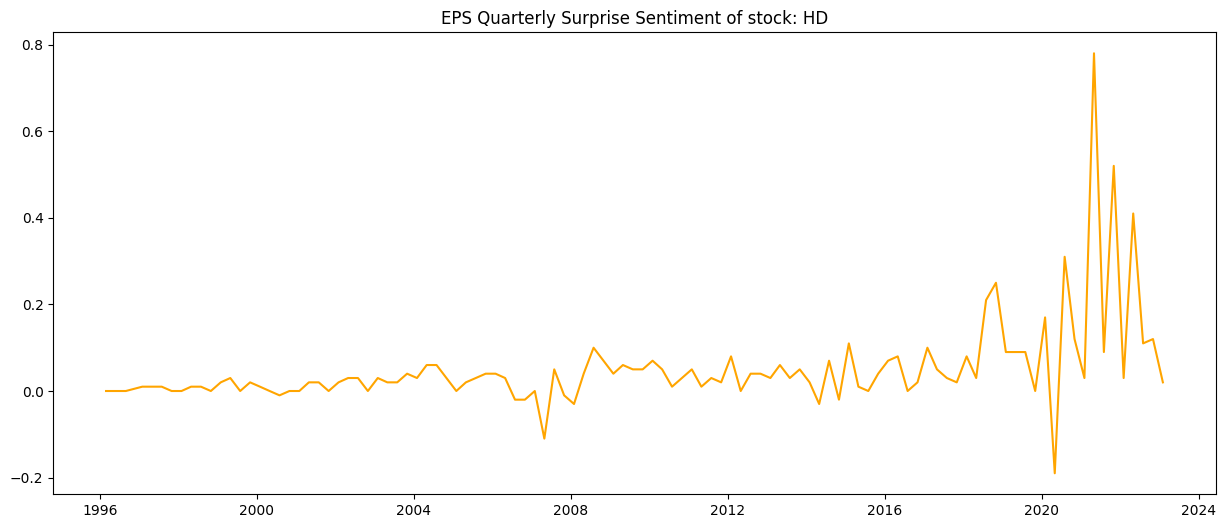

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(Surprise_EPS_data_quarterly['fiscalDateEnding'],Surprise_EPS_data_quarterly['EPS_quarterly_surprise_sentiment'], color="orange")
plt.title(f'EPS Quarterly Surprise Sentiment of stock: {COMPANY_TICKET}')
plt.show()

## Federal Reserve Interest Rate

In [ ]:
fred = Fred(api_key=FRED_ECONOMIC_DATA_API_KEY)
data = fred.get_series('FEDFUNDS')
FED_interest_rates = pd.DataFrame({'Date': data.index, 'FED_InterestRate': data.values})
# FED_interest_rates.set_index('Date', inplace=True)

In [ ]:
# df_since_date = df.loc[init_date:]

In [ ]:
FED_interest_rates

,Date,FED_InterestRate
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83
...,...,...
820,2022-11-01,3.78
821,2022-12-01,4.10
822,2023-01-01,4.33
823,2023-02-01,4.57


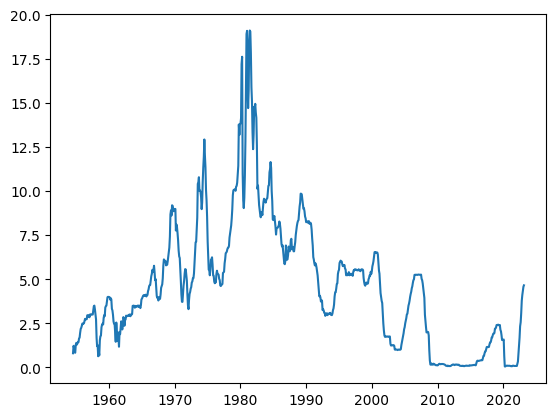

In [ ]:
plt.plot(FED_interest_rates["Date"],FED_interest_rates["FED_InterestRate"])
plt.show()

## CPI (Consumer price index)

In [ ]:
fred = Fred(api_key=FRED_ECONOMIC_DATA_API_KEY)
data = fred.get_series('CORESTICKM159SFRBATL')

CPI_data = pd.DataFrame({'CPI_Date': data.index, 'CPI': data.values})
# cpi_index_data.set_index('Date', inplace=True)

In [ ]:
# df_since_date = cpi_index_data.loc[init_date:]

In [ ]:
CPI_data.head(5)

,CPI_Date,CPI
0,1967-12-01,3.383497
1,1968-01-01,3.659987
2,1968-02-01,3.682012
3,1968-03-01,4.151668
4,1968-04-01,4.165427


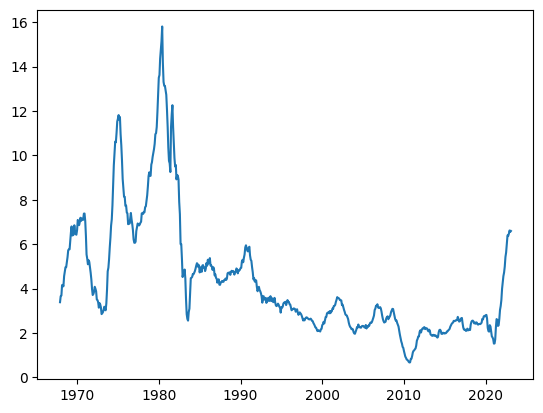

In [ ]:
plt.plot(CPI_data['CPI_Date'],CPI_data['CPI'])
plt.show()

## Join Data

In [ ]:
join_data= pd.DataFrame()

### Join with Stock price

In [ ]:
#Copying Stock price data
join_data= STOCK_PRICE_Data.copy()

In [ ]:
join_data.shape

(2582, 6)

In [ ]:
join_data['StockPrice_Year'] = join_data['StockPriceDate'].dt.year.astype(int)
join_data['StockPrice_Quarter'] = join_data['StockPriceDate'].dt.quarter.astype(int)
join_data['StockPrice_Month'] = join_data['StockPriceDate'].dt.month.astype(int)
join_data['StockPrice_Day'] = join_data['StockPriceDate'].dt.day.astype(int)

In [ ]:
join_data.head(150)

,StockPriceDate,closePrice,highestPrice,lowestPrice,openPrice,volumen,StockPrice_Year,StockPrice_Quarter,StockPrice_Month,StockPrice_Day
0,2013-01-02,63.4800,63.7100,62.61,63.57,9072207,2013,1,1,2
1,2013-01-03,63.3000,63.9300,63.08,63.78,6057180,2013,1,1,3
2,2013-01-04,63.1800,63.3700,63.00,63.21,4780124,2013,1,1,4
3,2013-01-07,62.8412,63.0000,62.38,62.60,5467113,2013,1,1,7
4,2013-01-08,63.2200,63.4600,62.73,62.75,5433220,2013,1,1,8
...,...,...,...,...,...,...,...,...,...,...
145,2013-07-31,79.0300,79.7300,78.69,78.69,5914986,2013,3,7,31
146,2013-08-01,78.6400,79.9700,78.61,79.52,6728402,2013,3,8,1
147,2013-08-02,80.2300,80.5000,78.50,78.64,5964909,2013,3,8,2
148,2013-08-05,79.6600,79.9548,79.37,79.95,3578466,2013,3,8,5


In [ ]:
join_data['StockPricePrevious_Year'] = (join_data['StockPriceDate'].apply(lambda x: (pd.to_datetime(x) - pd.DateOffset(years=1)).year)).astype(int)

In [ ]:
join_data['StockPriceDatePrevious_Quarter'] = (join_data['StockPriceDate']- pd.DateOffset(months=3)).dt.quarter.astype(int)

In [ ]:
join_data['StockPriceDatePrevious_Quarter_Year'] = (join_data['StockPriceDate']- pd.DateOffset(months=3)).dt.year.astype(int)

In [ ]:
join_data['StockPriceDatePrevious_Month'] = (join_data['StockPriceDate'].dt.month-1).astype(int)

In [ ]:
join_data.loc[(join_data['StockPriceDatePrevious_Month']==0),'StockPriceDatePrevious_Month']=12

In [ ]:
join_data['StockPriceDatePrevious_Month_Year']=join_data['StockPrice_Year']

In [ ]:
join_data.loc[(join_data['StockPriceDatePrevious_Month']==12),'StockPriceDatePrevious_Month_Year']=join_data['StockPriceDatePrevious_Month_Year']-1

In [ ]:
join_data.head(260)

,StockPriceDate,closePrice,highestPrice,lowestPrice,openPrice,volumen,StockPrice_Year,StockPrice_Quarter,StockPrice_Month,StockPrice_Day,StockPricePrevious_Year,StockPriceDatePrevious_Quarter,StockPriceDatePrevious_Quarter_Year,StockPriceDatePrevious_Month,StockPriceDatePrevious_Month_Year
0,2013-01-02,63.4800,63.71,62.610,63.57,9072207,2013,1,1,2,2012,4,2012,12,2012
1,2013-01-03,63.3000,63.93,63.080,63.78,6057180,2013,1,1,3,2012,4,2012,12,2012
2,2013-01-04,63.1800,63.37,63.000,63.21,4780124,2013,1,1,4,2012,4,2012,12,2012
3,2013-01-07,62.8412,63.00,62.380,62.60,5467113,2013,1,1,7,2012,4,2012,12,2012
4,2013-01-08,63.2200,63.46,62.730,62.75,5433220,2013,1,1,8,2012,4,2012,12,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,2014-01-07,81.5000,81.92,81.080,81.31,4631656,2014,1,1,7,2013,4,2013,12,2013
256,2014-01-08,81.9300,81.94,81.030,81.54,4662392,2014,1,1,8,2013,4,2013,12,2013
257,2014-01-09,81.5700,81.94,80.975,81.90,4966067,2014,1,1,9,2013,4,2013,12,2013
258,2014-01-10,82.0100,82.04,81.420,81.72,4981041,2014,1,1,10,2013,4,2013,12,2013


### Join with Annual Ratios

In [ ]:
ratios_annual_copy=ratios_annual.copy()

In [ ]:
ratios_annual_copy.head(5)

,Annual_RatiosDate,Annual_Current_Ratio,Annual_PE_Ratio,Annual_Debt_Equity _Ratio,Annual_Asset_Turnover_annual,Annual_ROE%_decimal,Annual_PS_Ratio
10,2013,1.42,20.10,1.18,1.85,0.368,1.37
9,2014,1.36,21.69,1.84,1.99,0.590,1.65
8,2015,1.32,22.75,3.36,2.05,0.882,1.80
7,2016,1.25,21.18,5.45,2.15,1.387,1.78
6,2017,1.17,28.04,18.59,2.24,2.998,2.40


In [ ]:
ratios_annual_copy_columns_name_changed= ["Previous_"+col for col in ratios_annual_copy.columns]
ratios_annual_copy_columns=ratios_annual_copy.columns
change_Annual_Ratios_Names_dict= dict(zip(ratios_annual_copy_columns, ratios_annual_copy_columns_name_changed))

In [ ]:
join_data= pd.merge(join_data,ratios_annual_copy, how="left", left_on='StockPricePrevious_Year', right_on='Annual_RatiosDate')

In [ ]:
join_data.rename(columns=change_Annual_Ratios_Names_dict, inplace=True)

In [ ]:
join_data.head(100)

,StockPriceDate,closePrice,highestPrice,lowestPrice,openPrice,volumen,StockPrice_Year,StockPrice_Quarter,StockPrice_Month,StockPrice_Day,StockPricePrevious_Year,StockPriceDatePrevious_Quarter,StockPriceDatePrevious_Quarter_Year,StockPriceDatePrevious_Month,StockPriceDatePrevious_Month_Year,Previous_Annual_RatiosDate,Previous_Annual_Current_Ratio,Previous_Annual_PE_Ratio,Previous_Annual_Debt_Equity _Ratio,Previous_Annual_Asset_Turnover_annual,Previous_Annual_ROE%_decimal,Previous_Annual_PS_Ratio
0,2013-01-02,63.4800,63.71,62.6100,63.5700,9072207,2013,1,1,2,2012,4,2012,12,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-03,63.3000,63.93,63.0800,63.7800,6057180,2013,1,1,3,2012,4,2012,12,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-04,63.1800,63.37,63.0000,63.2100,4780124,2013,1,1,4,2012,4,2012,12,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-07,62.8412,63.00,62.3800,62.6000,5467113,2013,1,1,7,2012,4,2012,12,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-08,63.2200,63.46,62.7300,62.7500,5433220,2013,1,1,8,2012,4,2012,12,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2013-05-20,76.7600,77.00,76.5000,76.7701,8869822,2013,2,5,20,2012,1,2013,4,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,2013-05-21,78.7100,79.47,78.0600,79.3300,14113767,2013,2,5,21,2012,1,2013,4,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,2013-05-22,79.6900,81.56,79.1800,79.2600,14834854,2013,2,5,22,2012,1,2013,4,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,2013-05-23,78.9100,79.25,77.7901,78.8900,9634805,2013,2,5,23,2012,1,2013,4,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Join with Quarterly Ratios

In [ ]:
ratios_quarterly_copy=ratios_quarterly.copy()

In [ ]:
ratios_quarterly_copy.head(5)

,Quarterly_RatiosDate,Quarterly_Current_Ratio,Quarterly_PE_Ratio,Quarterly_PE_Debt_EquityRatio,Quarterly_PS_Ratio
40,2013-05-05,1.33,23.25,0.78,1.44
39,2013-08-04,1.30,23.49,0.82,1.50
38,2013-11-03,1.48,20.45,1.13,1.39
37,2014-02-02,1.42,20.10,1.18,1.37
36,2014-05-04,1.32,19.81,1.21,1.38


In [ ]:
ratios_quarterly_copy['QuarterlyRatio_Year'] = ratios_quarterly_copy['Quarterly_RatiosDate'].dt.year.astype(int)
ratios_quarterly_copy['QuarterlyRatio_Quarter'] = ratios_quarterly_copy['Quarterly_RatiosDate'].dt.quarter.astype(int)

In [ ]:
ratios_quarterly_copy.drop(columns=["Quarterly_RatiosDate"],inplace=True)

In [ ]:
ratios_quarterly_copy.head(5)

,Quarterly_Current_Ratio,Quarterly_PE_Ratio,Quarterly_PE_Debt_EquityRatio,Quarterly_PS_Ratio,QuarterlyRatio_Year,QuarterlyRatio_Quarter
40,1.33,23.25,0.78,1.44,2013,2
39,1.30,23.49,0.82,1.50,2013,3
38,1.48,20.45,1.13,1.39,2013,4
37,1.42,20.10,1.18,1.37,2014,1
36,1.32,19.81,1.21,1.38,2014,2


In [ ]:
ratios_quarterly_copy_columns_name_changed= ["Previous_"+col for col in ratios_quarterly_copy.columns]
ratios_quarterly_copy_columns=ratios_quarterly_copy.columns
change_Quarterly_Ratios_Names_dict= dict(zip(ratios_quarterly_copy_columns, ratios_quarterly_copy_columns_name_changed))

In [ ]:
join_data= pd.merge(join_data,ratios_quarterly_copy, how="left", left_on=['StockPriceDatePrevious_Quarter_Year','StockPriceDatePrevious_Quarter'], right_on=['QuarterlyRatio_Year','QuarterlyRatio_Quarter'])

In [ ]:
join_data.rename(columns=change_Quarterly_Ratios_Names_dict, inplace=True)

In [ ]:
join_data.head(150)

,StockPriceDate,closePrice,highestPrice,lowestPrice,openPrice,volumen,StockPrice_Year,StockPrice_Quarter,StockPrice_Month,StockPrice_Day,StockPricePrevious_Year,StockPriceDatePrevious_Quarter,StockPriceDatePrevious_Quarter_Year,StockPriceDatePrevious_Month,StockPriceDatePrevious_Month_Year,Previous_Annual_RatiosDate,Previous_Annual_Current_Ratio,Previous_Annual_PE_Ratio,Previous_Annual_Debt_Equity _Ratio,Previous_Annual_Asset_Turnover_annual,Previous_Annual_ROE%_decimal,Previous_Annual_PS_Ratio,Previous_Quarterly_Current_Ratio,Previous_Quarterly_PE_Ratio,Previous_Quarterly_PE_Debt_EquityRatio,Previous_Quarterly_PS_Ratio,Previous_QuarterlyRatio_Year,Previous_QuarterlyRatio_Quarter
0,2013-01-02,63.4800,63.7100,62.61,63.57,9072207,2013,1,1,2,2012,4,2012,12,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-03,63.3000,63.9300,63.08,63.78,6057180,2013,1,1,3,2012,4,2012,12,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-04,63.1800,63.3700,63.00,63.21,4780124,2013,1,1,4,2012,4,2012,12,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-07,62.8412,63.0000,62.38,62.60,5467113,2013,1,1,7,2012,4,2012,12,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-08,63.2200,63.4600,62.73,62.75,5433220,2013,1,1,8,2012,4,2012,12,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,2013-07-31,79.0300,79.7300,78.69,78.69,5914986,2013,3,7,31,2012,2,2013,6,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.33,23.25,0.78,1.44,2013.0,2.0
146,2013-08-01,78.6400,79.9700,78.61,79.52,6728402,2013,3,8,1,2012,2,2013,7,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.33,23.25,0.78,1.44,2013.0,2.0
147,2013-08-02,80.2300,80.5000,78.50,78.64,5964909,2013,3,8,2,2012,2,2013,7,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.33,23.25,0.78,1.44,2013.0,2.0
148,2013-08-05,79.6600,79.9548,79.37,79.95,3578466,2013,3,8,5,2012,2,2013,7,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.33,23.25,0.78,1.44,2013.0,2.0


### Join With EPS Sentiment

In [ ]:
EPS_sentiment_copy= Surprise_EPS_data_quarterly.copy()

In [ ]:
EPS_sentiment_copy.head(5)

,fiscalDateEnding,EPS_quarterly_surprise_sentiment
107,1996-02-29,0.00
106,1996-05-31,0.00
105,1996-08-31,0.00
104,1997-01-31,0.01
103,1997-04-30,0.01


In [ ]:
EPS_sentiment_copy['Quarterly_Sentiment_Ratio_Year'] = EPS_sentiment_copy['fiscalDateEnding'].dt.year.astype(int)
EPS_sentiment_copy['Quarterly_Sentiment_Ratio_Quarter'] = EPS_sentiment_copy['fiscalDateEnding'].dt.quarter.astype(int)

In [ ]:
EPS_sentiment_copy.drop(columns=["fiscalDateEnding"],inplace=True)

In [ ]:
EPS_sentiment_copy.head(5)

,EPS_quarterly_surprise_sentiment,Quarterly_Sentiment_Ratio_Year,Quarterly_Sentiment_Ratio_Quarter
107,0.00,1996,1
106,0.00,1996,2
105,0.00,1996,3
104,0.01,1997,1
103,0.01,1997,2


In [ ]:
join_data= pd.merge(join_data,EPS_sentiment_copy, how="left", left_on=['StockPriceDatePrevious_Quarter_Year','StockPriceDatePrevious_Quarter'], right_on=['Quarterly_Sentiment_Ratio_Year','Quarterly_Sentiment_Ratio_Quarter'])

In [ ]:
EPS_sentiment_copy_name_changed= ["Previous_"+col for col in EPS_sentiment_copy.columns]
EPS_sentiment_copy_columns=EPS_sentiment_copy.columns
EPS_sentiment_copy_columns_dict= dict(zip(EPS_sentiment_copy_columns, EPS_sentiment_copy_name_changed))

In [ ]:
join_data.rename(columns=EPS_sentiment_copy_columns_dict, inplace=True)

In [ ]:
join_data.head(5)

,StockPriceDate,closePrice,highestPrice,lowestPrice,openPrice,volumen,StockPrice_Year,StockPrice_Quarter,StockPrice_Month,StockPrice_Day,StockPricePrevious_Year,StockPriceDatePrevious_Quarter,StockPriceDatePrevious_Quarter_Year,StockPriceDatePrevious_Month,StockPriceDatePrevious_Month_Year,Previous_Annual_RatiosDate,Previous_Annual_Current_Ratio,Previous_Annual_PE_Ratio,Previous_Annual_Debt_Equity _Ratio,Previous_Annual_Asset_Turnover_annual,Previous_Annual_ROE%_decimal,Previous_Annual_PS_Ratio,Previous_Quarterly_Current_Ratio,Previous_Quarterly_PE_Ratio,Previous_Quarterly_PE_Debt_EquityRatio,Previous_Quarterly_PS_Ratio,Previous_QuarterlyRatio_Year,Previous_QuarterlyRatio_Quarter,Previous_EPS_quarterly_surprise_sentiment,Previous_Quarterly_Sentiment_Ratio_Year,Previous_Quarterly_Sentiment_Ratio_Quarter
0,2013-01-02,63.4800,63.71,62.61,63.57,9072207,2013,1,1,2,2012,4,2012,12,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,2012,4
1,2013-01-03,63.3000,63.93,63.08,63.78,6057180,2013,1,1,3,2012,4,2012,12,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,2012,4
2,2013-01-04,63.1800,63.37,63.00,63.21,4780124,2013,1,1,4,2012,4,2012,12,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,2012,4
3,2013-01-07,62.8412,63.00,62.38,62.60,5467113,2013,1,1,7,2012,4,2012,12,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,2012,4
4,2013-01-08,63.2200,63.46,62.73,62.75,5433220,2013,1,1,8,2012,4,2012,12,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,2012,4


### Join with FED interest Rates

In [ ]:
FED_interest_rates_copy=FED_interest_rates.copy()

In [ ]:
FED_interest_rates_copy.head(5)

,Date,FED_InterestRate
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83


In [ ]:
FED_interest_rates_copy['FED_InterestRate_Year'] = FED_interest_rates_copy['Date'].dt.year.astype(int)
FED_interest_rates_copy['FED_InterestRate_Month'] = FED_interest_rates_copy['Date'].dt.month.astype(int)

In [ ]:
FED_interest_rates_copy.drop(columns=["Date"],inplace=True)

In [ ]:
FED_interest_rates_copy.head(15)

,FED_InterestRate,FED_InterestRate_Year,FED_InterestRate_Month
0,0.80,1954,7
1,1.22,1954,8
2,1.07,1954,9
3,0.85,1954,10
4,0.83,1954,11
5,1.28,1954,12
6,1.39,1955,1
7,1.29,1955,2
8,1.35,1955,3
9,1.43,1955,4


In [ ]:
join_data= pd.merge(join_data,FED_interest_rates_copy, how="left", left_on=['StockPriceDatePrevious_Month_Year','StockPriceDatePrevious_Month'], right_on=['FED_InterestRate_Year','FED_InterestRate_Month'])

In [ ]:
FED_interest_rates_copy_name_changed= ["Previous_"+col for col in FED_interest_rates_copy.columns]
FED_interest_rates_copy_columns=FED_interest_rates_copy.columns
FED_interest_rates_copy_columns_dict= dict(zip(FED_interest_rates_copy_columns, FED_interest_rates_copy_name_changed))

In [ ]:
join_data.rename(columns=FED_interest_rates_copy_columns_dict, inplace=True)

In [ ]:
join_data.head(10)

,StockPriceDate,closePrice,highestPrice,lowestPrice,openPrice,volumen,StockPrice_Year,StockPrice_Quarter,StockPrice_Month,StockPrice_Day,StockPricePrevious_Year,StockPriceDatePrevious_Quarter,StockPriceDatePrevious_Quarter_Year,StockPriceDatePrevious_Month,StockPriceDatePrevious_Month_Year,Previous_Annual_RatiosDate,Previous_Annual_Current_Ratio,Previous_Annual_PE_Ratio,Previous_Annual_Debt_Equity _Ratio,Previous_Annual_Asset_Turnover_annual,Previous_Annual_ROE%_decimal,Previous_Annual_PS_Ratio,Previous_Quarterly_Current_Ratio,Previous_Quarterly_PE_Ratio,Previous_Quarterly_PE_Debt_EquityRatio,Previous_Quarterly_PS_Ratio,Previous_QuarterlyRatio_Year,Previous_QuarterlyRatio_Quarter,Previous_EPS_quarterly_surprise_sentiment,Previous_Quarterly_Sentiment_Ratio_Year,Previous_Quarterly_Sentiment_Ratio_Quarter,Previous_FED_InterestRate,Previous_FED_InterestRate_Year,Previous_FED_InterestRate_Month
0,2013-01-02,63.4800,63.71,62.610,63.57,9072207,2013,1,1,2,2012,4,2012,12,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,2012,4,0.16,2012,12
1,2013-01-03,63.3000,63.93,63.080,63.78,6057180,2013,1,1,3,2012,4,2012,12,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,2012,4,0.16,2012,12
2,2013-01-04,63.1800,63.37,63.000,63.21,4780124,2013,1,1,4,2012,4,2012,12,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,2012,4,0.16,2012,12
3,2013-01-07,62.8412,63.00,62.380,62.60,5467113,2013,1,1,7,2012,4,2012,12,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,2012,4,0.16,2012,12
4,2013-01-08,63.2200,63.46,62.730,62.75,5433220,2013,1,1,8,2012,4,2012,12,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,2012,4,0.16,2012,12
5,2013-01-09,63.1700,63.63,63.010,63.51,4712397,2013,1,1,9,2012,4,2012,12,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,2012,4,0.16,2012,12
6,2013-01-10,63.6200,63.62,62.780,63.38,6714096,2013,1,1,10,2012,4,2012,12,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,2012,4,0.16,2012,12
7,2013-01-11,63.7000,63.76,63.342,63.47,4569202,2013,1,1,11,2012,4,2012,12,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,2012,4,0.16,2012,12
8,2013-01-14,63.4800,63.90,63.390,63.66,4532612,2013,1,1,14,2012,4,2012,12,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,2012,4,0.16,2012,12
9,2013-01-15,63.9500,64.01,63.450,63.50,5119318,2013,1,1,15,2012,4,2012,12,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,2012,4,0.16,2012,12


### Join with CPI index

In [ ]:
CPI_data_copy=CPI_data.copy()

In [ ]:
CPI_data_copy.head(5)

,CPI_Date,CPI
0,1967-12-01,3.383497
1,1968-01-01,3.659987
2,1968-02-01,3.682012
3,1968-03-01,4.151668
4,1968-04-01,4.165427


In [ ]:
CPI_data_copy['CPI_index_Year'] = CPI_data_copy['CPI_Date'].dt.year.astype(int)
CPI_data_copy['CPI_index_Month'] = CPI_data_copy['CPI_Date'].dt.month.astype(int)

In [ ]:
CPI_data_copy.head(5)

,CPI_Date,CPI,CPI_index_Year,CPI_index_Month
0,1967-12-01,3.383497,1967,12
1,1968-01-01,3.659987,1968,1
2,1968-02-01,3.682012,1968,2
3,1968-03-01,4.151668,1968,3
4,1968-04-01,4.165427,1968,4


In [ ]:
join_data= pd.merge(join_data,CPI_data_copy, how="left", left_on=['StockPriceDatePrevious_Month_Year','StockPriceDatePrevious_Month'], right_on=['CPI_index_Year','CPI_index_Month'])

In [ ]:
CPI_copy_name_changed= ["Previous_"+col for col in CPI_data_copy.columns]
CPI_copy_columns=CPI_data_copy.columns
CPI_copy_columns_dict= dict(zip(CPI_copy_columns, CPI_copy_name_changed))

In [ ]:
join_data.rename(columns=CPI_copy_columns_dict, inplace=True)

In [ ]:
join_data.head(5)

,StockPriceDate,closePrice,highestPrice,lowestPrice,openPrice,volumen,StockPrice_Year,StockPrice_Quarter,StockPrice_Month,StockPrice_Day,StockPricePrevious_Year,StockPriceDatePrevious_Quarter,StockPriceDatePrevious_Quarter_Year,StockPriceDatePrevious_Month,StockPriceDatePrevious_Month_Year,Previous_Annual_RatiosDate,Previous_Annual_Current_Ratio,Previous_Annual_PE_Ratio,Previous_Annual_Debt_Equity _Ratio,Previous_Annual_Asset_Turnover_annual,Previous_Annual_ROE%_decimal,Previous_Annual_PS_Ratio,Previous_Quarterly_Current_Ratio,Previous_Quarterly_PE_Ratio,Previous_Quarterly_PE_Debt_EquityRatio,Previous_Quarterly_PS_Ratio,Previous_QuarterlyRatio_Year,Previous_QuarterlyRatio_Quarter,Previous_EPS_quarterly_surprise_sentiment,Previous_Quarterly_Sentiment_Ratio_Year,Previous_Quarterly_Sentiment_Ratio_Quarter,Previous_FED_InterestRate,Previous_FED_InterestRate_Year,Previous_FED_InterestRate_Month,Previous_CPI_Date,Previous_CPI,Previous_CPI_index_Year,Previous_CPI_index_Month
0,2013-01-02,63.4800,63.71,62.61,63.57,9072207,2013,1,1,2,2012,4,2012,12,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,2012,4,0.16,2012,12,2012-12-01,2.10973,2012.0,12.0
1,2013-01-03,63.3000,63.93,63.08,63.78,6057180,2013,1,1,3,2012,4,2012,12,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,2012,4,0.16,2012,12,2012-12-01,2.10973,2012.0,12.0
2,2013-01-04,63.1800,63.37,63.00,63.21,4780124,2013,1,1,4,2012,4,2012,12,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,2012,4,0.16,2012,12,2012-12-01,2.10973,2012.0,12.0
3,2013-01-07,62.8412,63.00,62.38,62.60,5467113,2013,1,1,7,2012,4,2012,12,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,2012,4,0.16,2012,12,2012-12-01,2.10973,2012.0,12.0
4,2013-01-08,63.2200,63.46,62.73,62.75,5433220,2013,1,1,8,2012,4,2012,12,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,2012,4,0.16,2012,12,2012-12-01,2.10973,2012.0,12.0


## Preparing Join

In [ ]:
join_data_copy=join_data.copy()

In [ ]:
join_data_copy.head(500)

,StockPriceDate,closePrice,highestPrice,lowestPrice,openPrice,volumen,StockPrice_Year,StockPrice_Quarter,StockPrice_Month,StockPrice_Day,StockPricePrevious_Year,StockPriceDatePrevious_Quarter,StockPriceDatePrevious_Quarter_Year,StockPriceDatePrevious_Month,StockPriceDatePrevious_Month_Year,Previous_Annual_RatiosDate,Previous_Annual_Current_Ratio,Previous_Annual_PE_Ratio,Previous_Annual_Debt_Equity _Ratio,Previous_Annual_Asset_Turnover_annual,Previous_Annual_ROE%_decimal,Previous_Annual_PS_Ratio,Previous_Quarterly_Current_Ratio,Previous_Quarterly_PE_Ratio,Previous_Quarterly_PE_Debt_EquityRatio,Previous_Quarterly_PS_Ratio,Previous_QuarterlyRatio_Year,Previous_QuarterlyRatio_Quarter,Previous_EPS_quarterly_surprise_sentiment,Previous_Quarterly_Sentiment_Ratio_Year,Previous_Quarterly_Sentiment_Ratio_Quarter,Previous_FED_InterestRate,Previous_FED_InterestRate_Year,Previous_FED_InterestRate_Month,Previous_CPI_Date,Previous_CPI,Previous_CPI_index_Year,Previous_CPI_index_Month
0,2013-01-02,63.4800,63.7100,62.61,63.57,9072207,2013,1,1,2,2012,4,2012,12,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,2012,4,0.16,2012,12,2012-12-01,2.109730,2012.0,12.0
1,2013-01-03,63.3000,63.9300,63.08,63.78,6057180,2013,1,1,3,2012,4,2012,12,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,2012,4,0.16,2012,12,2012-12-01,2.109730,2012.0,12.0
2,2013-01-04,63.1800,63.3700,63.00,63.21,4780124,2013,1,1,4,2012,4,2012,12,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,2012,4,0.16,2012,12,2012-12-01,2.109730,2012.0,12.0
3,2013-01-07,62.8412,63.0000,62.38,62.60,5467113,2013,1,1,7,2012,4,2012,12,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,2012,4,0.16,2012,12,2012-12-01,2.109730,2012.0,12.0
4,2013-01-08,63.2200,63.4600,62.73,62.75,5433220,2013,1,1,8,2012,4,2012,12,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,2012,4,0.16,2012,12,2012-12-01,2.109730,2012.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2014-12-18,100.6700,100.6900,99.30,100.34,6593962,2014,4,12,18,2013,3,2014,11,2014,2013.0,1.42,20.1,1.18,1.85,0.368,1.37,1.44,18.83,1.46,1.35,2014.0,3.0,0.07,2014,3,0.09,2014,11,2014-11-01,2.004366,2014.0,11.0
496,2014-12-19,101.9300,102.0000,100.81,100.92,12500604,2014,4,12,19,2013,3,2014,11,2014,2013.0,1.42,20.1,1.18,1.85,0.368,1.37,1.44,18.83,1.46,1.35,2014.0,3.0,0.07,2014,3,0.09,2014,11,2014-11-01,2.004366,2014.0,11.0
497,2014-12-22,103.5000,103.5700,102.23,102.25,5418865,2014,4,12,22,2013,3,2014,11,2014,2013.0,1.42,20.1,1.18,1.85,0.368,1.37,1.44,18.83,1.46,1.35,2014.0,3.0,0.07,2014,3,0.09,2014,11,2014-11-01,2.004366,2014.0,11.0
498,2014-12-23,103.7600,104.2000,103.32,103.66,4067739,2014,4,12,23,2013,3,2014,11,2014,2013.0,1.42,20.1,1.18,1.85,0.368,1.37,1.44,18.83,1.46,1.35,2014.0,3.0,0.07,2014,3,0.09,2014,11,2014-11-01,2.004366,2014.0,11.0


In [ ]:
join_data_copy.columns

Index(['StockPriceDate', 'closePrice', 'highestPrice', 'lowestPrice',
       'openPrice', 'volumen', 'StockPrice_Year', 'StockPrice_Quarter',
       'StockPrice_Month', 'StockPrice_Day', 'StockPricePrevious_Year',
       'StockPriceDatePrevious_Quarter', 'StockPriceDatePrevious_Quarter_Year',
       'StockPriceDatePrevious_Month', 'StockPriceDatePrevious_Month_Year',
       'Previous_Annual_RatiosDate', 'Previous_Annual_Current_Ratio',
       'Previous_Annual_PE_Ratio', 'Previous_Annual_Debt_Equity _Ratio',
       'Previous_Annual_Asset_Turnover_annual', 'Previous_Annual_ROE%_decimal',
       'Previous_Annual_PS_Ratio', 'Previous_Quarterly_Current_Ratio',
       'Previous_Quarterly_PE_Ratio', 'Previous_Quarterly_PE_Debt_EquityRatio',
       'Previous_Quarterly_PS_Ratio', 'Previous_QuarterlyRatio_Year',
       'Previous_QuarterlyRatio_Quarter',
       'Previous_EPS_quarterly_surprise_sentiment',
       'Previous_Quarterly_Sentiment_Ratio_Year',
       'Previous_Quarterly_Sentiment_Ratio

In [ ]:
dropColumns=["StockPrice_Year","StockPrice_Quarter","StockPrice_Month","StockPrice_Day","StockPricePrevious_Year","StockPriceDatePrevious_Quarter","StockPriceDatePrevious_Quarter_Year",
             "StockPriceDatePrevious_Month","StockPriceDatePrevious_Month_Year","Previous_Annual_RatiosDate","Previous_QuarterlyRatio_Year","Previous_QuarterlyRatio_Quarter","Previous_Quarterly_Sentiment_Ratio_Year","Previous_Quarterly_Sentiment_Ratio_Quarter","Previous_FED_InterestRate_Year","Previous_FED_InterestRate_Month","Previous_CPI_Date","Previous_CPI_index_Year","Previous_CPI_index_Month"]

In [ ]:
join_data_copy.drop(columns=dropColumns,inplace=True)

In [ ]:
join_data_copy.columns

Index(['StockPriceDate', 'closePrice', 'highestPrice', 'lowestPrice',
       'openPrice', 'volumen', 'Previous_Annual_Current_Ratio',
       'Previous_Annual_PE_Ratio', 'Previous_Annual_Debt_Equity _Ratio',
       'Previous_Annual_Asset_Turnover_annual', 'Previous_Annual_ROE%_decimal',
       'Previous_Annual_PS_Ratio', 'Previous_Quarterly_Current_Ratio',
       'Previous_Quarterly_PE_Ratio', 'Previous_Quarterly_PE_Debt_EquityRatio',
       'Previous_Quarterly_PS_Ratio',
       'Previous_EPS_quarterly_surprise_sentiment',
       'Previous_FED_InterestRate', 'Previous_CPI'],
      dtype='object')

In [ ]:
join_data_copy.shape

(2582, 19)

In [ ]:
join_data_copy

,StockPriceDate,closePrice,highestPrice,lowestPrice,openPrice,volumen,Previous_Annual_Current_Ratio,Previous_Annual_PE_Ratio,Previous_Annual_Debt_Equity _Ratio,Previous_Annual_Asset_Turnover_annual,Previous_Annual_ROE%_decimal,Previous_Annual_PS_Ratio,Previous_Quarterly_Current_Ratio,Previous_Quarterly_PE_Ratio,Previous_Quarterly_PE_Debt_EquityRatio,Previous_Quarterly_PS_Ratio,Previous_EPS_quarterly_surprise_sentiment,Previous_FED_InterestRate,Previous_CPI
0,2013-01-02,63.4800,63.710,62.6100,63.57,9072207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,0.16,2.10973
1,2013-01-03,63.3000,63.930,63.0800,63.78,6057180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,0.16,2.10973
2,2013-01-04,63.1800,63.370,63.0000,63.21,4780124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,0.16,2.10973
3,2013-01-07,62.8412,63.000,62.3800,62.60,5467113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,0.16,2.10973
4,2013-01-08,63.2200,63.460,62.7300,62.75,5433220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,0.16,2.10973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2577,2023-03-29,283.3600,283.990,281.2500,281.25,3607467,1.41,18.87,32.24,2.06,49.294,2.05,1.39,17.89,38.30,1.94,0.12,4.57,6.59375
2578,2023-03-30,285.3600,286.095,283.8511,285.36,3432765,1.41,18.87,32.24,2.06,49.294,2.05,1.39,17.89,38.30,1.94,0.12,4.57,6.59375
2579,2023-03-31,295.1200,295.550,286.7600,286.99,5800560,1.41,18.87,32.24,2.06,49.294,2.05,1.39,17.89,38.30,1.94,0.12,4.57,6.59375
2580,2023-04-03,297.7300,297.970,294.7350,294.87,4007558,1.41,18.87,32.24,2.06,49.294,2.05,1.41,18.87,32.24,2.05,0.02,4.65,NaN


In [ ]:
join_data_copy.index=join_data_copy["StockPriceDate"]

In [ ]:
join_data_copy.drop(columns=["StockPriceDate"],inplace=True)

In [ ]:
join_data_copy

,closePrice,highestPrice,lowestPrice,openPrice,volumen,Previous_Annual_Current_Ratio,Previous_Annual_PE_Ratio,Previous_Annual_Debt_Equity _Ratio,Previous_Annual_Asset_Turnover_annual,Previous_Annual_ROE%_decimal,Previous_Annual_PS_Ratio,Previous_Quarterly_Current_Ratio,Previous_Quarterly_PE_Ratio,Previous_Quarterly_PE_Debt_EquityRatio,Previous_Quarterly_PS_Ratio,Previous_EPS_quarterly_surprise_sentiment,Previous_FED_InterestRate,Previous_CPI
StockPriceDate,,,,,,,,,,,,,,,,,,
2013-01-02,63.4800,63.710,62.6100,63.57,9072207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,0.16,2.10973
2013-01-03,63.3000,63.930,63.0800,63.78,6057180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,0.16,2.10973
2013-01-04,63.1800,63.370,63.0000,63.21,4780124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,0.16,2.10973
2013-01-07,62.8412,63.000,62.3800,62.60,5467113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,0.16,2.10973
2013-01-08,63.2200,63.460,62.7300,62.75,5433220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,0.16,2.10973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-29,283.3600,283.990,281.2500,281.25,3607467,1.41,18.87,32.24,2.06,49.294,2.05,1.39,17.89,38.30,1.94,0.12,4.57,6.59375
2023-03-30,285.3600,286.095,283.8511,285.36,3432765,1.41,18.87,32.24,2.06,49.294,2.05,1.39,17.89,38.30,1.94,0.12,4.57,6.59375
2023-03-31,295.1200,295.550,286.7600,286.99,5800560,1.41,18.87,32.24,2.06,49.294,2.05,1.39,17.89,38.30,1.94,0.12,4.57,6.59375


In [ ]:
join_data_copy.isna().sum()

closePrice                                     0
highestPrice                                   0
lowestPrice                                    0
openPrice                                      0
volumen                                        0
Previous_Annual_Current_Ratio                252
Previous_Annual_PE_Ratio                     252
Previous_Annual_Debt_Equity _Ratio           252
Previous_Annual_Asset_Turnover_annual        252
Previous_Annual_ROE%_decimal                 252
Previous_Annual_PS_Ratio                     252
Previous_Quarterly_Current_Ratio             124
Previous_Quarterly_PE_Ratio                  124
Previous_Quarterly_PE_Debt_EquityRatio       124
Previous_Quarterly_PS_Ratio                  124
Previous_EPS_quarterly_surprise_sentiment      0
Previous_FED_InterestRate                      0
Previous_CPI                                   2
dtype: int64

In [ ]:
median_replaceable_columns=join_data_copy.columns[:-1]
join_data_copy[median_replaceable_columns]= join_data_copy[median_replaceable_columns].fillna(join_data_copy[median_replaceable_columns].median())

In [ ]:
last_non_nan_idx = np.max(np.where(~np.isnan(join_data_copy["Previous_CPI"])))
last_non_nan_value = join_data_copy["Previous_CPI"][last_non_nan_idx]
join_data_copy["Previous_CPI"]=join_data_copy["Previous_CPI"].fillna(last_non_nan_value)

In [ ]:
join_data_copy.isna().sum()

closePrice                                   0
highestPrice                                 0
lowestPrice                                  0
openPrice                                    0
volumen                                      0
Previous_Annual_Current_Ratio                0
Previous_Annual_PE_Ratio                     0
Previous_Annual_Debt_Equity _Ratio           0
Previous_Annual_Asset_Turnover_annual        0
Previous_Annual_ROE%_decimal                 0
Previous_Annual_PS_Ratio                     0
Previous_Quarterly_Current_Ratio             0
Previous_Quarterly_PE_Ratio                  0
Previous_Quarterly_PE_Debt_EquityRatio       0
Previous_Quarterly_PS_Ratio                  0
Previous_EPS_quarterly_surprise_sentiment    0
Previous_FED_InterestRate                    0
Previous_CPI                                 0
dtype: int64

In [ ]:
join_data_copy

,closePrice,highestPrice,lowestPrice,openPrice,volumen,Previous_Annual_Current_Ratio,Previous_Annual_PE_Ratio,Previous_Annual_Debt_Equity _Ratio,Previous_Annual_Asset_Turnover_annual,Previous_Annual_ROE%_decimal,Previous_Annual_PS_Ratio,Previous_Quarterly_Current_Ratio,Previous_Quarterly_PE_Ratio,Previous_Quarterly_PE_Debt_EquityRatio,Previous_Quarterly_PS_Ratio,Previous_EPS_quarterly_surprise_sentiment,Previous_FED_InterestRate,Previous_CPI
StockPriceDate,,,,,,,,,,,,,,,,,,
2013-01-02,63.4800,63.710,62.6100,63.57,9072207,1.23,22.13,1.84,2.10,1.387,1.93,1.21,22.59,2.74,1.94,0.04,0.16,2.10973
2013-01-03,63.3000,63.930,63.0800,63.78,6057180,1.23,22.13,1.84,2.10,1.387,1.93,1.21,22.59,2.74,1.94,0.04,0.16,2.10973
2013-01-04,63.1800,63.370,63.0000,63.21,4780124,1.23,22.13,1.84,2.10,1.387,1.93,1.21,22.59,2.74,1.94,0.04,0.16,2.10973
2013-01-07,62.8412,63.000,62.3800,62.60,5467113,1.23,22.13,1.84,2.10,1.387,1.93,1.21,22.59,2.74,1.94,0.04,0.16,2.10973
2013-01-08,63.2200,63.460,62.7300,62.75,5433220,1.23,22.13,1.84,2.10,1.387,1.93,1.21,22.59,2.74,1.94,0.04,0.16,2.10973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-29,283.3600,283.990,281.2500,281.25,3607467,1.41,18.87,32.24,2.06,49.294,2.05,1.39,17.89,38.30,1.94,0.12,4.57,6.59375
2023-03-30,285.3600,286.095,283.8511,285.36,3432765,1.41,18.87,32.24,2.06,49.294,2.05,1.39,17.89,38.30,1.94,0.12,4.57,6.59375
2023-03-31,295.1200,295.550,286.7600,286.99,5800560,1.41,18.87,32.24,2.06,49.294,2.05,1.39,17.89,38.30,1.94,0.12,4.57,6.59375


In [ ]:
join_data_copy.dtypes

closePrice                                   float64
highestPrice                                 float64
lowestPrice                                  float64
openPrice                                    float64
volumen                                        int64
Previous_Annual_Current_Ratio                float64
Previous_Annual_PE_Ratio                     float64
Previous_Annual_Debt_Equity _Ratio           float64
Previous_Annual_Asset_Turnover_annual        float64
Previous_Annual_ROE%_decimal                 float64
Previous_Annual_PS_Ratio                     float64
Previous_Quarterly_Current_Ratio             float64
Previous_Quarterly_PE_Ratio                  float64
Previous_Quarterly_PE_Debt_EquityRatio       float64
Previous_Quarterly_PS_Ratio                  float64
Previous_EPS_quarterly_surprise_sentiment    float64
Previous_FED_InterestRate                    float64
Previous_CPI                                 float64
dtype: object

## Split data

In [ ]:
join_data_copy.head(5)

,closePrice,highestPrice,lowestPrice,openPrice,volumen,Previous_Annual_Current_Ratio,Previous_Annual_PE_Ratio,Previous_Annual_Debt_Equity _Ratio,Previous_Annual_Asset_Turnover_annual,Previous_Annual_ROE%_decimal,Previous_Annual_PS_Ratio,Previous_Quarterly_Current_Ratio,Previous_Quarterly_PE_Ratio,Previous_Quarterly_PE_Debt_EquityRatio,Previous_Quarterly_PS_Ratio,Previous_EPS_quarterly_surprise_sentiment,Previous_FED_InterestRate,Previous_CPI
StockPriceDate,,,,,,,,,,,,,,,,,,
2013-01-02,63.4800,63.71,62.61,63.57,9072207,1.23,22.13,1.84,2.1,1.387,1.93,1.21,22.59,2.74,1.94,0.04,0.16,2.10973
2013-01-03,63.3000,63.93,63.08,63.78,6057180,1.23,22.13,1.84,2.1,1.387,1.93,1.21,22.59,2.74,1.94,0.04,0.16,2.10973
2013-01-04,63.1800,63.37,63.00,63.21,4780124,1.23,22.13,1.84,2.1,1.387,1.93,1.21,22.59,2.74,1.94,0.04,0.16,2.10973
2013-01-07,62.8412,63.00,62.38,62.60,5467113,1.23,22.13,1.84,2.1,1.387,1.93,1.21,22.59,2.74,1.94,0.04,0.16,2.10973
2013-01-08,63.2200,63.46,62.73,62.75,5433220,1.23,22.13,1.84,2.1,1.387,1.93,1.21,22.59,2.74,1.94,0.04,0.16,2.10973


In [ ]:
coeff_train = 0.80  #proportion of the dataset in the training set
TRAIN_SPLIT = round(join_data_copy.shape[0]*coeff_train)
print(TRAIN_SPLIT)

coeff_validation_boundary = coeff_train+0.1 ## This represents the boundary of the validation data which will be the next 10% of the data after the train set, and the last 10 % of the data will be the test
VALIDATION_SPLIT_BOUNDARY = round(join_data_copy.shape[0]*coeff_validation_boundary)
print(VALIDATION_SPLIT_BOUNDARY)

2066
2324


In [ ]:
def multivariate_data(x_data, start_index, end_index,input_size ,target_size, targetLabel):
    data = []
    labels = []
    start_index = start_index + input_size
    if end_index is None:
        end_index = len(x_data) - target_size

    for i in range(start_index, end_index):
        data.append(x_data[(i-input_size):i])
        #labels.append(list(x_data[i+1:i+target_size+1][targetLabel]))
        labels.append(list(x_data[i:i+target_size][targetLabel]))
    return np.array(data), np.array(labels)

In [ ]:
#TIME_HORIZON_DAYS=91
TIME_HORIZON_DAYS=91

INPUT_SIZE=TIME_HORIZON_DAYS*1
OUTPUT_SIZE=1


x_train,y_train = multivariate_data(join_data_copy, 0,TRAIN_SPLIT,INPUT_SIZE,OUTPUT_SIZE,"closePrice")
x_val,y_val = multivariate_data(join_data_copy, TRAIN_SPLIT, VALIDATION_SPLIT_BOUNDARY,INPUT_SIZE,OUTPUT_SIZE,"closePrice")
x_test,y_test = multivariate_data(join_data_copy, VALIDATION_SPLIT_BOUNDARY, None,INPUT_SIZE,OUTPUT_SIZE,"closePrice")

In [ ]:
x_train

array([[[6.3480000e+01, 6.3710000e+01, 6.2610000e+01, ...,
         4.0000000e-02, 1.6000000e-01, 2.1097305e+00],
        [6.3300000e+01, 6.3930000e+01, 6.3080000e+01, ...,
         4.0000000e-02, 1.6000000e-01, 2.1097305e+00],
        [6.3180000e+01, 6.3370000e+01, 6.3000000e+01, ...,
         4.0000000e-02, 1.6000000e-01, 2.1097305e+00],
        ...,
        [7.5870000e+01, 7.6180000e+01, 7.5360000e+01, ...,
         3.0000000e-02, 1.5000000e-01, 1.9354319e+00],
        [7.6010000e+01, 7.6200000e+01, 7.5410000e+01, ...,
         3.0000000e-02, 1.5000000e-01, 1.9354319e+00],
        [7.6670000e+01, 7.6850000e+01, 7.5950000e+01, ...,
         3.0000000e-02, 1.5000000e-01, 1.9354319e+00]],

       [[6.3300000e+01, 6.3930000e+01, 6.3080000e+01, ...,
         4.0000000e-02, 1.6000000e-01, 2.1097305e+00],
        [6.3180000e+01, 6.3370000e+01, 6.3000000e+01, ...,
         4.0000000e-02, 1.6000000e-01, 2.1097305e+00],
        [6.2841200e+01, 6.3000000e+01, 6.2380000e+01, ...,
         4.000

In [ ]:
x_train.shape

(1975, 91, 18)

In [ ]:
y_train

array([[ 77.32],
       [ 77.88],
       [ 76.75],
       ...,
       [278.54],
       [282.08],
       [280.03]])

In [ ]:
y_train.shape

(1975, 1)

In [ ]:
x_train_mean = np.mean(x_train, axis=(0, 1))
x_train_std = np.std(x_train, axis=(0, 1))

#Let's standardize the data:
x_train_scaled = (x_train-x_train_mean)/x_train_std
x_val_scaled = (x_val-x_train_mean)/x_train_std
x_test_scaled = (x_test-x_train_mean)/x_train_std

In [ ]:
train_plt=np.concatenate(y_train, axis=0)
val_plt=np.concatenate(y_val, axis=0)
test_plt=np.concatenate(y_test, axis=0)

In [ ]:
train_len=len(train_plt)
val_len=len(val_plt)+train_len
test_len=len(test_plt)+val_len

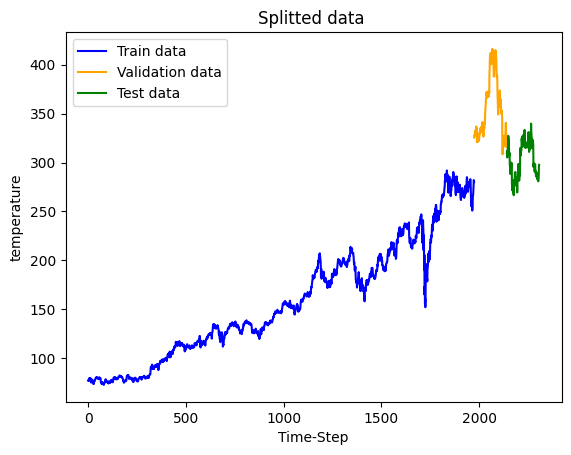

In [ ]:
plt.title('Splitted data ')
plt.xlabel('Time-Step')
plt.ylabel('temperature')
plt.plot(np.arange(0,train_len),train_plt, label="Train data", color="blue")
plt.plot(np.arange(train_len,val_len),val_plt, label="Validation data", color="orange")
plt.plot(np.arange(val_len,test_len),test_plt, label="Test data", color="green")
plt.legend(loc="upper left")
plt.show()

## Training Model

In [ ]:
tf.random.set_seed(42)

In [ ]:
BATCH_SIZE = 32
BUFFER_SIZE = 10000

train_multivariate = tf.data.Dataset.from_tensor_slices((x_train_scaled, y_train))
train_multivariate = train_multivariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_multivariate = tf.data.Dataset.from_tensor_slices((x_val_scaled, y_val))
val_multivariate = val_multivariate.batch(BATCH_SIZE).repeat()

test_multivariate = tf.data.Dataset.from_tensor_slices((x_test_scaled, y_test))
test_multivariate = test_multivariate.batch(BATCH_SIZE).repeat()

In [ ]:
for input_example, target_example in train_multivariate.take(1):
  print("Input :",input_example)
  print("Target:",target_example)

Input : tf.Tensor(
[[[ 0.96436558  0.96663532  0.98523674 ... -0.34122977  1.39750426
    0.59118899]
  [ 0.95786767  0.9512338   0.96536018 ... -0.34122977  1.39750426
    0.59118899]
  [ 0.94641081  0.94285605  0.9776318  ... -0.34122977  1.39750426
    0.59118899]
  ...
  [ 0.41135849  0.41090793  0.4090343  ...  2.21069549  1.84015617
    0.70271358]
  [ 0.40759653  0.40168733  0.39464367 ...  2.21069549  1.84015617
    0.70271358]
  [ 0.41443645  0.39271722  0.40795233 ...  2.21069549  1.84015617
    0.70271358]]

 [[-0.51801491 -0.51681857 -0.51103606 ... -0.57322297 -0.79116356
   -0.44087137]
  [-0.55597644 -0.53814375 -0.53851757 ... -0.57322297 -0.79116356
   -0.44087137]
  [-0.6308735  -0.57487045 -0.61439417 ... -0.57322297 -0.79116356
   -0.44087137]
  ...
  [-0.34103212 -0.35518726 -0.34251741 ... -0.68921958 -0.80345944
    0.49338576]
  [-0.34462308 -0.35281779 -0.32903592 ... -0.68921958 -0.80345944
    0.49338576]
  [-0.34838503 -0.36263415 -0.34234457 ... -0.68921958

In [ ]:
join_data_copy.shape[1]

18

In [ ]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(2048,input_shape=(INPUT_SIZE, join_data_copy.shape[1])),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation=activations.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation=activations.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(OUTPUT_SIZE)
])

lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae')

In [ ]:
lstm_model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 2048)              16932864  
                                                                 
 batch_normalization_73 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense_74 (Dense)            (None, 512)               1049088   
                                                                 
 batch_normalization_74 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_75 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_75 (Bat  (None, 256)            

In [ ]:
for x,y in test_multivariate.take(1):
    print(x.shape)
    pr= lstm_model.predict(x)
    print(pr)
    print(pr.shape)

(32, 91, 18)
1/1 [==============================] - 0s 469ms/step
[[-0.38681272]
 [-0.3869685 ]
 [-0.38816804]
 [-0.3885138 ]
 [-0.39020902]
 [-0.3911248 ]
 [-0.39162776]
 [-0.3927039 ]
 [-0.39590117]
 [-0.39984083]
 [-0.40066296]
 [-0.4013499 ]
 [-0.4008729 ]
 [-0.3998398 ]
 [-0.39840853]
 [-0.39756978]
 [-0.3966943 ]
 [-0.39502943]
 [-0.3940794 ]
 [-0.3932864 ]
 [-0.39808896]
 [-0.40158683]
 [-0.40317285]
 [-0.40435964]
 [-0.40534428]
 [-0.40614346]
 [-0.4065298 ]
 [-0.40616864]
 [-0.4064038 ]
 [-0.40647614]
 [-0.4039879 ]
 [-0.405981  ]]
(32, 1)


In [ ]:
callback_early = EarlyStopping(monitor='val_loss', mode='min', patience=20)
callback_checkpoint= ModelCheckpoint(filepath='/tmp/checkpoints',monitor='val_loss', mode='min',save_best_only=True)

In [ ]:
STEPS_PER_EPOCH = x_train.shape[0]//BATCH_SIZE
VAL_STEPS = x_val.shape[0]//BATCH_SIZE
print(STEPS_PER_EPOCH)
print(VAL_STEPS)

61
5


In [ ]:
EPOCHS=500
history = lstm_model.fit(train_multivariate, epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,callbacks=[callback_early,callback_checkpoint], validation_data=val_multivariate, validation_steps = VAL_STEPS)

Epoch 1/500
61/61 [==============================] - ETA: 0s - loss: 156.6775

61/61 [==============================] - 17s 225ms/step - loss: 156.6775 - val_loss: 354.3638
Epoch 2/500
61/61 [==============================] - ETA: 0s - loss: 151.7119

61/61 [==============================] - 13s 217ms/step - loss: 151.7119 - val_loss: 346.8192
Epoch 3/500
61/61 [==============================] - ETA: 0s - loss: 143.0740

61/61 [==============================] - 23s 384ms/step - loss: 143.0740 - val_loss: 337.2658
Epoch 4/500
61/61 [==============================] - ETA: 0s - loss: 129.0902

61/61 [==============================] - 13s 222ms/step - loss: 129.0902 - val_loss: 317.5026
Epoch 5/500
61/61 [==============================] - ETA: 0s - loss: 107.4785

61/61 [==============================] - 14s 224ms/step - loss: 107.4785 - val_loss: 293.3492
Epoch 6/500
61/61 [==============================] - 8s 134ms/step - loss: 85.0839 - val_loss: 310.4558
Epoch 7/500
61/61 [==============================] - ETA: 0s - loss: 55.9642

61/61 [==============================] - 14s 225ms/step - loss: 55.9642 - val_loss: 207.3074
Epoch 8/500
61/61 [==============================] - ETA: 0s - loss: 27.7055

61/61 [==============================] - 13s 221ms/step - loss: 27.7055 - val_loss: 152.9062
Epoch 9/500
61/61 [==============================] - ETA: 0s - loss: 14.1473

61/61 [==============================] - 13s 221ms/step - loss: 14.1473 - val_loss: 147.9433
Epoch 10/500
61/61 [==============================] - ETA: 0s - loss: 13.9868

61/61 [==============================] - 13s 221ms/step - loss: 13.9868 - val_loss: 15.7879
Epoch 11/500
61/61 [==============================] - 8s 129ms/step - loss: 12.4582 - val_loss: 64.2598
Epoch 12/500
61/61 [==============================] - ETA: 0s - loss: 11.4795

61/61 [==============================] - 14s 228ms/step - loss: 11.4795 - val_loss: 12.9651
Epoch 13/500
61/61 [==============================] - ETA: 0s - loss: 13.4378

61/61 [==============================] - 14s 223ms/step - loss: 13.4378 - val_loss: 10.6788
Epoch 14/500
61/61 [==============================] - ETA: 0s - loss: 11.9004

61/61 [==============================] - 13s 220ms/step - loss: 11.9004 - val_loss: 8.5826
Epoch 15/500
61/61 [==============================] - 8s 128ms/step - loss: 11.6375 - val_loss: 21.1654
Epoch 16/500
61/61 [==============================] - 8s 130ms/step - loss: 12.3222 - val_loss: 29.0020
Epoch 17/500
61/61 [==============================] - 8s 131ms/step - loss: 12.4688 - val_loss: 54.0120
Epoch 18/500
61/61 [==============================] - 8s 131ms/step - loss: 11.6909 - val_loss: 14.7635
Epoch 19/500
61/61 [==============================] - 8s 130ms/step - loss: 10.4437 - val_loss: 33.2548
Epoch 20/500
61/61 [==============================] - 8s 129ms/step - loss: 10.4497 - val_loss: 11.8692
Epoch 21/500
61/61 [==============================] - 8s 128ms/step - loss: 10.8400 - val_loss: 13.3552
Epoch 22/500
61/61 [==============================] - 8s 127ms/step - loss: 10.8054 - val_loss: 15.2922
Epoch 23/500
61/61 [==============================] - 8s 127ms/step - loss: 1

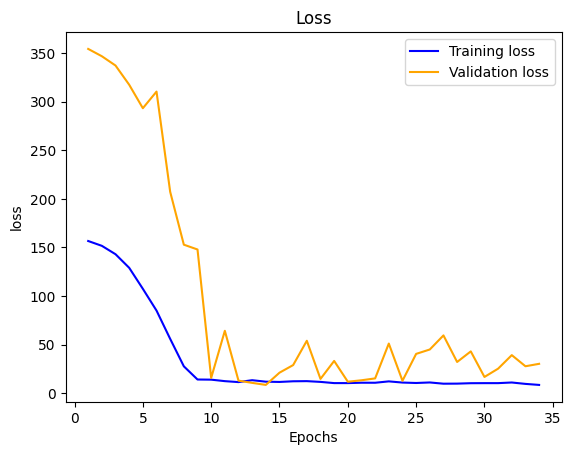

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
lstm_model.load_weights('/tmp/checkpoints')

In [ ]:
prediction= lstm_model.predict(x_test_scaled)
print(prediction)
print(prediction.shape)

6/6 [==============================] - 1s 49ms/step
[[306.49384]
 [307.7894 ]
 [311.2955 ]
 [309.1444 ]
 [310.36807]
 [312.14575]
 [313.3053 ]
 [313.37943]
 [317.01083]
 [322.9159 ]
 [323.56064]
 [322.81018]
 [318.29465]
 [312.496  ]
 [309.52444]
 [309.82468]
 [307.13348]
 [301.52463]
 [298.8615 ]
 [294.28796]
 [290.90128]
 [292.67056]
 [290.92093]
 [292.5377 ]
 [295.47888]
 [297.93216]
 [298.22934]
 [289.09402]
 [280.707  ]
 [276.35004]
 [272.63693]
 [275.48163]
 [274.93567]
 [274.60416]
 [271.51526]
 [269.79483]
 [269.1391 ]
 [269.34827]
 [274.34735]
 [275.9488 ]
 [276.1334 ]
 [268.2061 ]
 [257.10522]
 [255.59268]
 [256.08142]
 [253.16278]
 [250.30647]
 [249.21638]
 [248.74452]
 [245.36559]
 [246.39864]
 [246.47377]
 [249.74078]
 [245.81195]
 [240.86342]
 [238.89943]
 [243.41652]
 [249.80396]
 [252.7723 ]
 [254.82254]
 [257.27213]
 [258.65387]
 [259.81998]
 [257.1274 ]
 [249.89597]
 [248.1583 ]
 [250.1164 ]
 [252.78595]
 [252.22993]
 [261.49332]
 [270.47034]
 [271.06396]
 [269.67407]

In [ ]:
print(mean_squared_error(y_test,prediction))
print(mean_absolute_error(y_test,prediction))

781.9987558560642
23.42271378114999


In [ ]:
prediction_plt=np.concatenate(prediction, axis=0)

In [ ]:
prediction_len=len(prediction_plt)

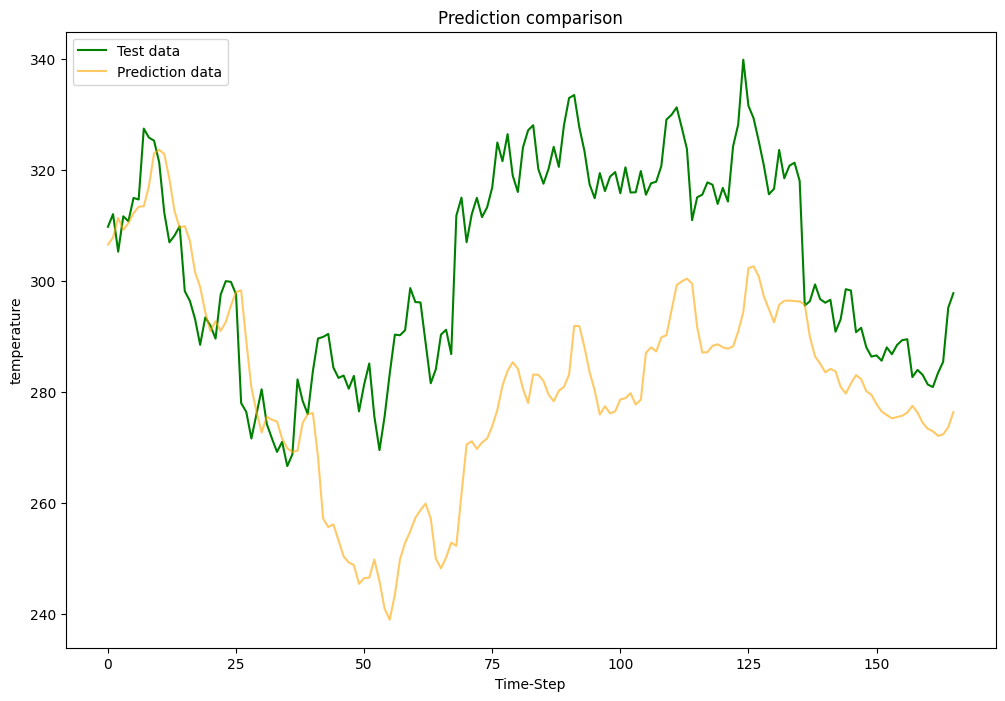

In [ ]:
plt.figure(figsize=(12,8))
plt.title('Prediction comparison')
plt.xlabel('Time-Step')
plt.ylabel('temperature')
plt.plot(np.arange(0,prediction_len),test_plt,color="green", label="Test data")
plt.plot(np.arange(0,prediction_len),prediction_plt,color="orange",label="Prediction data", alpha=0.6)
plt.legend(loc="upper left")
plt.show()